# Case 4: OCR of D4BL COVID-19 Data with Selenium 

Author: Sydeaka Watson in support for Data 4 Black Lives effort to monitor racial/ethnic disparities in COVID-19 cases and deaths

In this notebook, we use Optical Character Recognition (OCR) to read race/ethnicity data from COVID-19 dashboards. Selenium will be used to automatically visit the link (using a Google Chrome web browser), take a screenshot, and crop the image to capture the race/ethnicity table for OCR parsing.

Reference: https://stackabuse.com/pytesseract-simple-python-optical-character-recognition/

Step 1: Install tesseract-ocr
https://github.com/tesseract-ocr/tesseract/wiki#homebrew

For MAC OS, follow instructions to install homebrew at https://brew.sh
`brew install tesseract`


Step 2: Install a few additional packages
`pip install pytesseract`
`pip install Pillow` 

#  Notes about data

I started working on pulling data for Louisiana and New York State (the first 2 of this type).
In the HTML for the Louisiana website, I found a link to public tableau dashboard that zooms in on the table without any headers or footers.
http://public.tableau.com/views/COVID19demog/DataonCOVIN-19RelatedDeathsToDate?:embed=y&:showVizHome=no&:host_url=https%3A%2F%2Fpublic.tableau.com%2F&:embed_code_version=3&:device=phone&:tabs=no&:toolbar=no&:showAppBanner=false&:loadOrderID=1

And the dashboard for NY State is here:
https://covid19tracker.health.ny.gov/views/NYS-COVID19-Tracker/NYSDOHCOVID-19Tracker-Fatalities?%3Aembed=yes&%3Atoolbar=no&%3Atabs=n

# Setup

### Set parameters

In [2]:
import os

DOCKER_PORT = 32771

PROJECT_ROOT = os.path.abspath('.')
home_dir = PROJECT_ROOT
DRIVER_BIN = '/usr/local/bin/chromedriver' # Path to Google Chrome installation

### Load modules

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display, HTML

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

from selenium import webdriver
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
import time



# Open CV
import cv2

import docker

### Load helper functions

In [4]:
def ocr_core(filename):
    """
    This function will handle the core OCR processing of images.
    """
    text = pytesseract.image_to_string(Image.open(filename))  # We'll use Pillow's Image class to open the image and pytesseract to detect the string in the image
    return text


def proc_ocr_txt(txt_raw):
    """
    This function will split OCR text output on newlines ('\n') and remove blank lines.
    """
    txt = txt_raw.split('\n')
    txt_list = [x for x in txt if x.strip(' ') != '']
    return txt_list

def display_image(image_path, fig_size=(20,10)):
    """
    This function will display image when provided a path to the image.
    """
    image = plt.imread(image_path)
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.imshow(image)
    ax.axis('off')
    #plt.imshow(image)
    plt.show()

In [16]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

driver = webdriver.Firefox()
driver.get('https://www.arcgis.com/apps/opsdashboard/index.html#/69b726e2b82e408f89c3a54f96e8f776')

In [17]:
driver.close()

In [48]:
docker_url = 'http://localhost:{}/wd/hub'.format(DOCKER_PORT)
browser = webdriver.Remote(docker_url, DesiredCapabilities.FIREFOX)

In [49]:
browser.set_window_position(x=0,y=500)
browser.set_window_size(1024, 600)
browser.maximize_window()

In [50]:
target_url = 'https://www.arcgis.com/apps/opsdashboard/index.html#/69b726e2b82e408f89c3a54f96e8f776'
browser.get(target_url)
time.sleep(10)
png_filename = os.path.join(home_dir, 'screenshots', 'firefox_louisiana_arcgis.png')
browser.save_screenshot(png_filename)

True

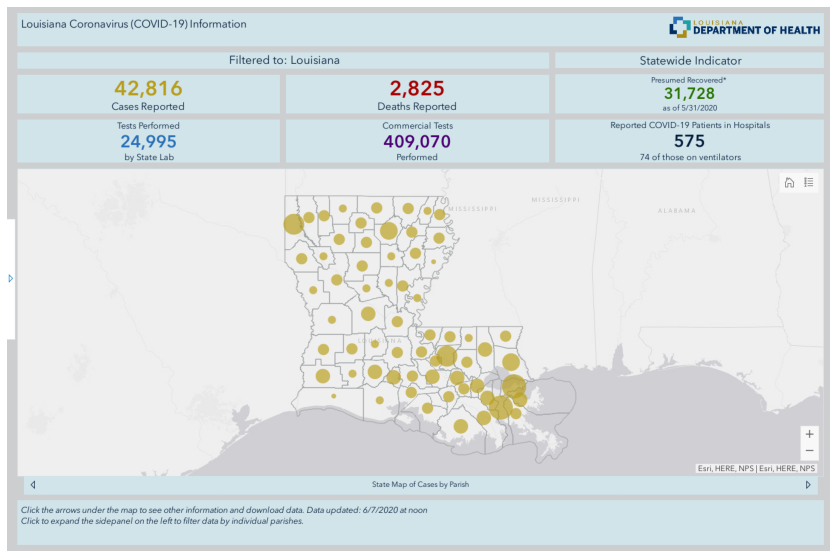

In [51]:
display_image(png_filename)

In [52]:
browser.close()

In [5]:
browser_image = 'selenium/standalone-firefox-debug'
#browser_image = 'selenium/standalone-chrome-debug'

def start_docker(port_number = DOCKER_PORT, VNC_PORT = 32770):
    try:
        client = docker.from_env()
        client.containers.run(browser_image, 
                              detach = True,  publish_all_ports = True,
                              ports =  {'4444/tcp': port_number,  '5900/tcp': VNC_PORT} 
                             )

        print('IDs of running docker containers:')
        print(client.containers.list())
        return client
    except Exception as inst:
        print("Error starting docker container")
        print(inst)
        
        
    
def stop_docker(client):
    try:
        client.containers.list()[0].stop()
    except Exception as inst:
        print("Error stopping docker container")
        print(inst)


In [ ]:
DesiredCapabilities.FIREFOX

In [6]:
def get_screenshot(location_name, sleep_seconds=5, show_image = False, 
                   screenshot_end_of_page = False,
                   use_docker=True, port_number=None):
    target_url = dashboard_urls[location_name] 
    output_filename = png_screenshots[location_name]
    
    if use_docker:
        #client = start_docker()
        time.sleep(3)
        # docker_url = "http://127.0.0.1:4444/wd/hub" # without selenium-chrome-debug
        docker_url = 'http://localhost:{}/wd/hub'.format(port_number)
        browser = webdriver.Remote(docker_url, DesiredCapabilities.CHROME)
    else:
        opts = webdriver.ChromeOptions()
        opts.add_argument("--kiosk")
        opts.add_argument('headless')
        browser = webdriver.Chrome(executable_path = DRIVER_BIN, options=opts)
    
    
    browser.get(target_url)
    browser.set_window_position(x=0,y=50)
    browser.set_window_size(1024, 600)
    browser.maximize_window()


    #browser.set_window_size(1024, 600)
    #browser.maximize_window()
    
    #browser.execute_script("window.scrollTo(0, 0);")  # scroll to top of page
    #browser.set_window_position(x=0,y=50)
    time.sleep(sleep_seconds)
    png_filename = os.path.join(home_dir, 'screenshots', "{}.png".format(output_filename))
    browser.save_screenshot(png_filename)
    print('Screenshot saved to {}'.format(png_filename))
    
    if screenshot_end_of_page:
        print('Scroll down and take another screenshot')
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        png_filename = os.path.join(home_dir, 'screenshots', "{}_endofpage.png".format(output_filename))
        browser.save_screenshot(png_filename)
        print('Screenshot saved to {}'.format(png_filename))
    
    #time.sleep(10)
    browser.close()
    if show_image:
        display_image(png_filename)

    #return browser
    #if use_docker:
        #stop_docker(client)


def get_crop(location, show_image = False):
    image_file = os.path.join(home_dir, 'screenshots', "{}.png".format(png_screenshots[location]))
    
    # Opens a image in RGB mode 
    im = Image.open(image_file) 
    
    # Size of the image in pixels (size of orginal image) 
    width, height = im.size 
    
    ## Get bounding box of area to crop
    crop_bbox = get_crop_boundary(location, width, height)
    
    # Cropped image of above dimension 
    # (It will not change orginal image) 
    im1 = im.crop((crop_bbox['left'], 
                   crop_bbox['top'], 
                   crop_bbox['right'], 
                   crop_bbox['bottom'])) 

    # Shows the image in image viewer 
    # out_file = os.path.join('screenshots', "cropped_{}.png".format(location))
    out_file = png_cropped[location]
    im1.save(out_file) 
    if show_image:
        display_image(out_file)
    





## Helper function to split out % fatalities from % population for each racial/ethnic group
def parse_nyc(nyc_dict):
    pct_deaths = {key: {'Pct Deaths': nyc_dict[key].split(' ')[0].replace('%', '')} for key in nyc_dict.keys()}
    pct_pop = {key: {'Pct Popn': nyc_dict[key].split(' ')[1].replace('%', '')} for key in nyc_dict.keys()}
    nyc_output_df = pd.DataFrame(pct_deaths).T
    nyc_output_df['Pct Popn'] = pd.DataFrame(pct_pop).T['Pct Popn']
    
    return nyc_output_df

In [7]:
def ocr_table(loc, port_number = DOCKER_PORT, screenshot_end_of_page = False):
    
    if loc in ['Louisiana']:
        screenshot_end_of_page = True
    
    print('\n\n\nScreenshot of {} dashboard'.format(loc))
    browser = get_screenshot(loc, show_image=False, port_number=port_number, 
                            screenshot_end_of_page = screenshot_end_of_page)
    #return browser
    print('Crop image')
    get_crop(loc, show_image=True)
    png_path = png_cropped[loc]
    print('Image pre-processing for Tesseract')
    png_preprocessed = image_preprocessing(png_path)
    print('Get raw OCR output from tesseract')
    txt_raw = ocr_core(png_preprocessed);  print(txt_raw)
    print('Split OCR text output on newlines and remove blank lines.')
    txt = proc_ocr_txt(txt_raw);  # print(txt)
    if loc == 'Louisiana':
        names_la = txt[0:7] #;  print(names_la)
        vals_la = txt[7:] #; print(vals_la)
        dict_la = {names_la[i]: {'Pct Deaths': float(vals_la[i].replace('%', ''))} for i in range(len(names_la))}
        out = pd.DataFrame(dict_la).T
        #display(out)
        return(out)
        
    if loc == 'New York State':
        ## Getting the raw outputs for cell in the table
        ## This case will require a separate step to split the % deaths from the % population values
        names_nystate = ['Hispanic', 'Black', 'White', 'Asian', 'Other']
        vals_nystate = [x for x in txt if 'population' in x]; # print(vals_nystate)
        nyc = {names_nystate[i]: vals_nystate[i].replace('(', '').replace(' of population)', '') for i in range(len(names_nystate))}
        nys_excl_nyc = {names_nystate[i]: vals_nystate[len(names_nystate) + i].replace('(', '').replace(' of population)', '') for i in range(len(names_nystate))}
        ## New York City Only
        display(parse_nyc(nyc))
        ## New York State excluding New York City
        display(parse_nyc(nys_excl_nyc))
        return({'New York City Only': parse_nyc(nyc),
               'New York State excluding New York City': parse_nyc(nys_excl_nyc)})
    
    #return browser

In [8]:
def data_extract_louisiana(validation=False, home_dir=None):
    try:
        location_name = 'Louisiana'

        print('Navigate to Louisiana data folder')
        dir = os.path.join(home_dir, 'data', 'louisiana')
        os.chdir(dir)

        print('Get OCR output')
        ocr_output =  ocr_table(location_name)
        #return ocr_output

        print('Get percent of AA deaths')
        la_aa_pct_deaths = ocr_output.loc['Black']['Pct Deaths']

        print('Get date from bottom of the page')
        la_bottom = os.path.join(home_dir, 'screenshots', 'screenshot_louisiana_endofpage.png')
        #display_image(la_bottom)
        txt_bottom_la = ocr_core(la_bottom).split('\n')
        o = [x for x in txt_bottom_la if 'Last updated' in x][0]
        la_date = o.split('Last updated ')[1].replace('.', '')
        
        os.chdir(home_dir)

        return {
            'Location': location_name,
            'Date Published': la_date,
            'Total Cases': np.nan,
            'Total Deaths': np.nan,
            'Count Cases Black/AA': np.nan,
            'Count Deaths Black/AA': np.nan,
            'Pct Cases Black/AA': np.nan,
            'Pct Deaths Black/AA': la_aa_pct_deaths,
            'Status code': success_code
            }
    except Exception as inst:
        print(inst)
        os.chdir(home_dir)
    
success_code = 'Success!'

# Use Selenium to get screenshots

References: 
* https://stackoverflow.com/questions/39428042/use-selenium-with-chromedriver-on-mac
* https://pythonspot.com/selenium-take-screenshot/

### Start Docker

In [37]:
client = start_docker()

IDs of running docker containers:
[<Container: 7e1a7d367f>]


In [10]:
dashboard_urls = {
    'Louisiana': "http://public.tableau.com/views/COVID19demog/DataonCOVIN-19RelatedDeathsToDate?:embed=y&:showVizHome=no&:host_url=https%3A%2F%2Fpublic.tableau.com%2F&:embed_code_version=3&:device=phone&:tabs=no&:toolbar=no&:showAppBanner=false&:loadOrderID=1",
    'New York State': "https://covid19tracker.health.ny.gov/views/NYS-COVID19-Tracker/NYSDOHCOVID-19Tracker-Fatalities?%3Aembed=yes&%3Atoolbar=no&%3Atabs=n"
}

png_screenshots = {
    'Louisiana': 'screenshot_louisiana',
    'New York State': 'screenshot_ny'
}

locations = list(dashboard_urls.keys()); locations

png_cropped = {loc: os.path.join(home_dir, 'screenshots', "cropped_{}.png".format(loc)) for loc in locations}; png_cropped

{'Louisiana': '/Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/cropped_Louisiana.png',
 'New York State': '/Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/cropped_New York State.png'}

In [11]:
def image_preprocessing(img_file):
    # Output filename
    out_file = img_file.replace('.png', '_preproc.png')
    
    # Read the image in with cv2, in grayscale
    img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
    display_image(img_file)
    
    # Enlarge image (make it 2x height and 2x width)
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    
    # Apply Gaussian blurring
    # img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.bilateralFilter(img,9,75,75)
    
    # Convert gray to RGB
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
    # Save the output to a file
    cv2.imwrite(out_file,img)
    
    display_image(out_file)
    
    return out_file

In [12]:
def get_crop_boundary(location, width, height):
    
    # selenium without docker
    # y = 350 # vertical offset for Louisiana
    # 'Louisiana': {'left': 0, 'top': height * 0.12  + y, 'right': width/3, 'bottom': 3 * height / 6 +  y}
    # 'New York State': {'left': 0.5 * width, 'top': height * 0.21, 'right': width, 'bottom': 0.45 * height}
    
    # selenium with docker
    y = -80 # vertical offset for Louisiana
    crop_boundaries = {
    #'Louisiana': {'left': 0, 'top': height * 0.18  + y, 'right': width/3, 'bottom': 0.70 * height+  y},
        'Louisiana': {'left': 0, 'top': height * 0.18  + y, 'right': width/3, 'bottom': 0.45 * height+  y},
    'New York State': {'left': 0.47 * width, 'top': height * 0.17, 'right': width, 'bottom': 0.31 * height},    
    }
    
    return crop_boundaries[location]



Navigate to Louisiana data folder
Get OCR output



Screenshot of Louisiana dashboard
Screenshot saved to /Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/screenshot_louisiana.png
Scroll down and take another screenshot
Screenshot saved to /Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/screenshot_louisiana_endofpage.png
Crop image


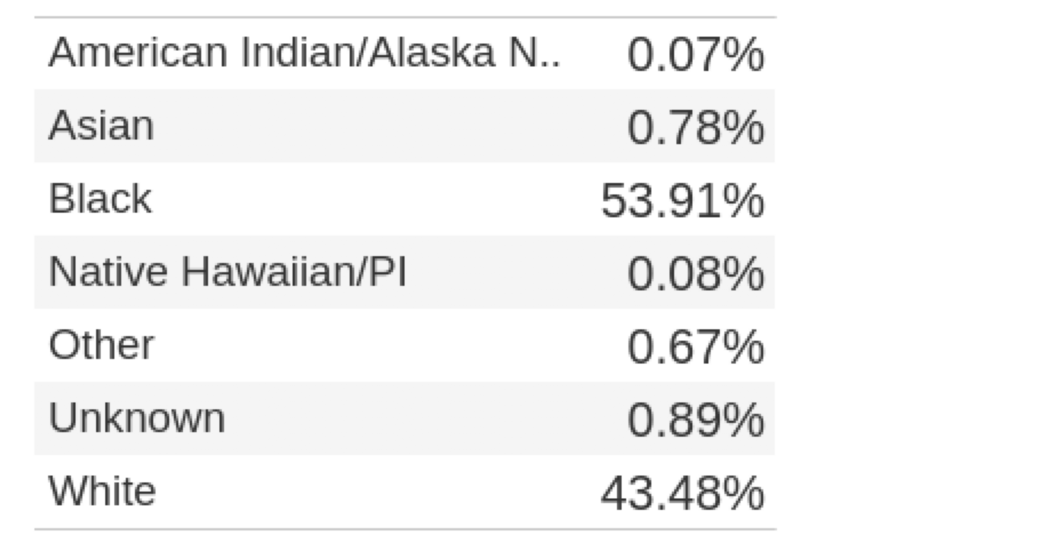

Image pre-processing for Tesseract


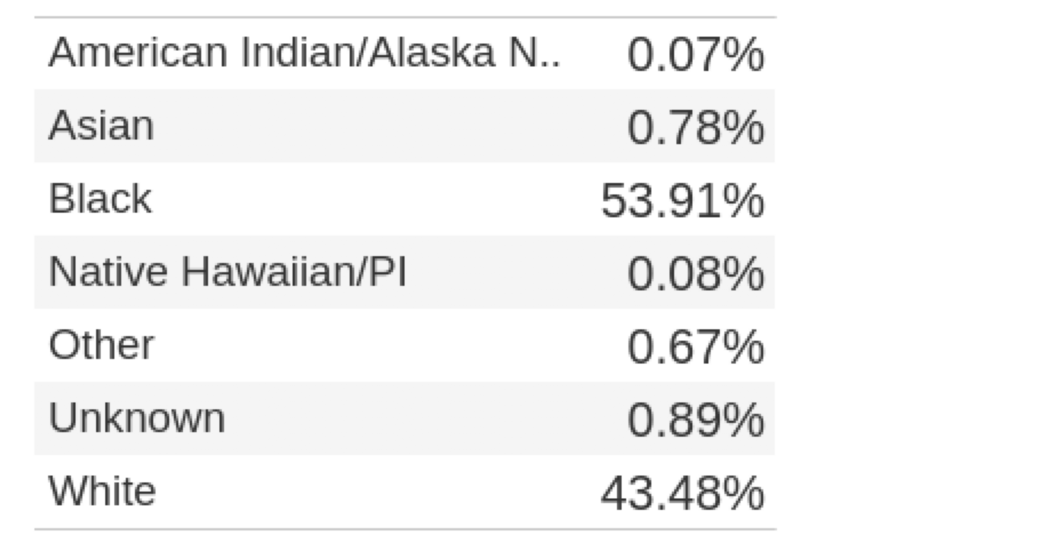

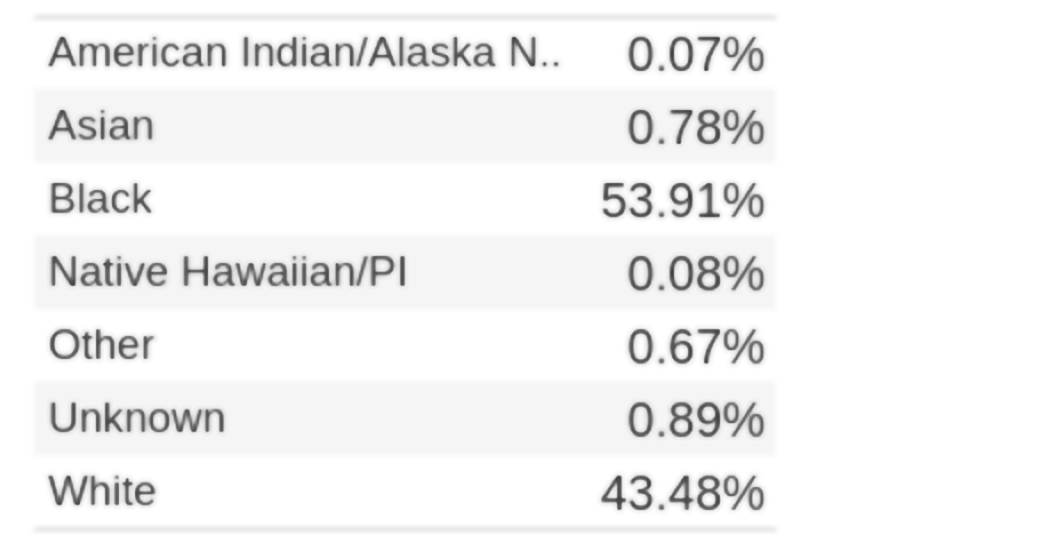

Get raw OCR output from tesseract
American Indian/Alaska N..

Asian

Black

Native Hawaiian/Pl
Other

Unknown

White

0.07%
0.78%
53.91%
0.08%
0.67%
0.89%
43.48%
Split OCR text output on newlines and remove blank lines.
Get percent of AA deaths
Get date from bottom of the page


{'Location': 'Louisiana',
 'Date Published': '6/1/2020',
 'Total Cases': nan,
 'Total Deaths': nan,
 'Count Cases Black/AA': nan,
 'Count Deaths Black/AA': nan,
 'Pct Cases Black/AA': nan,
 'Pct Deaths Black/AA': 53.91,
 'Status code': 'Success!'}

In [12]:
data_extract_louisiana(validation=False, home_dir=home_dir)

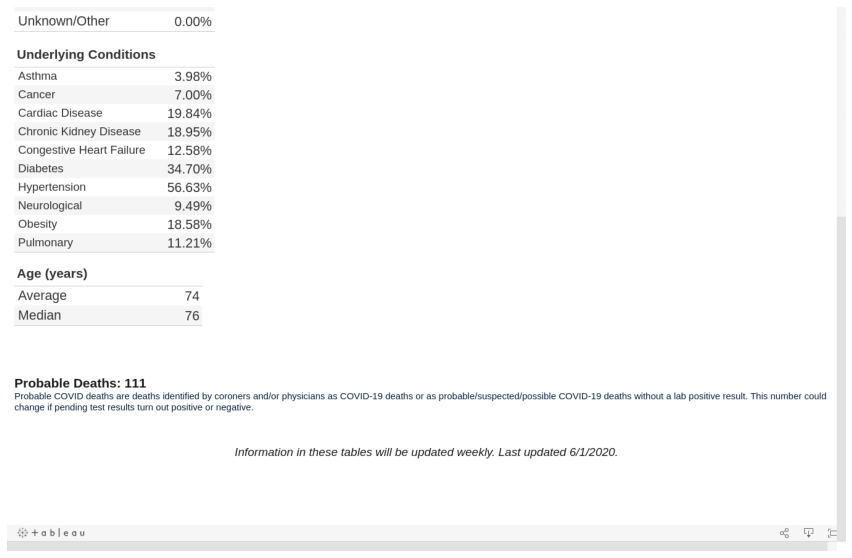

In [67]:
#display_image('screenshots/screenshot_louisiana.png')
display_image('screenshots/screenshot_louisiana_endofpage.png')
#display_image('screenshots/screenshot_ny.png')

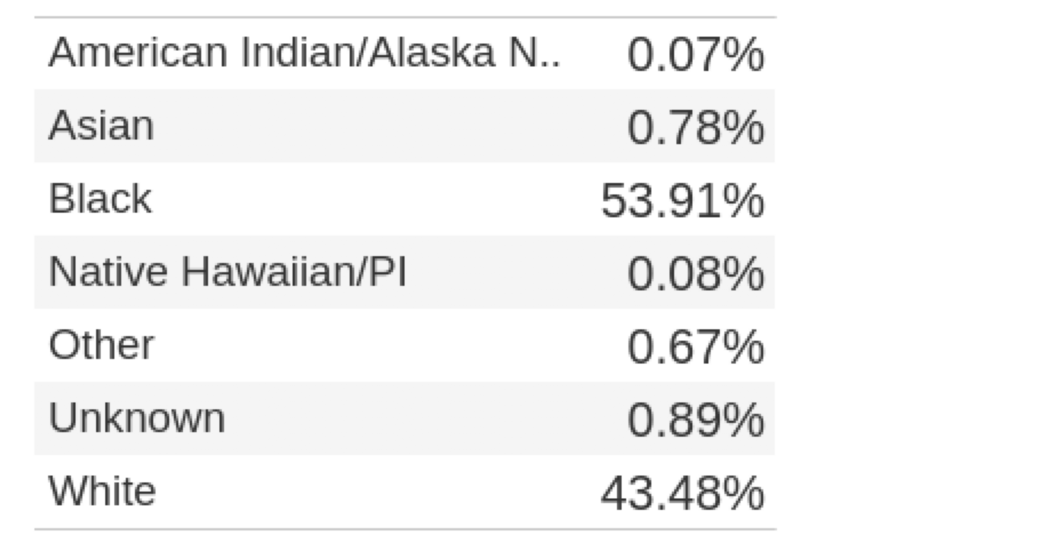

In [13]:
get_crop('Louisiana', show_image=True)




Screenshot of New York State dashboard
Screenshot saved to /Users/poisson/Documents/GitHub/COVID19_tracker_data_extraction/workflow/python/screenshots/screenshot_ny.png
Crop image


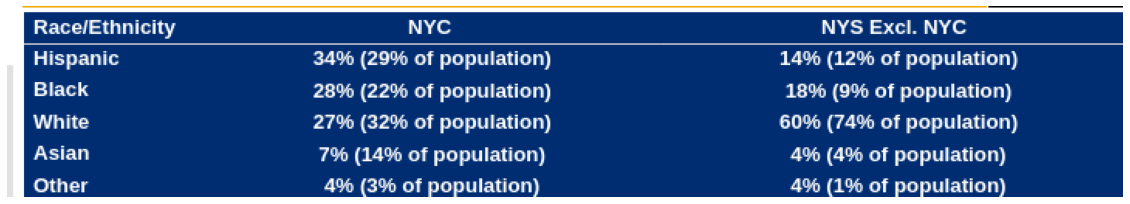

Image pre-processing for Tesseract


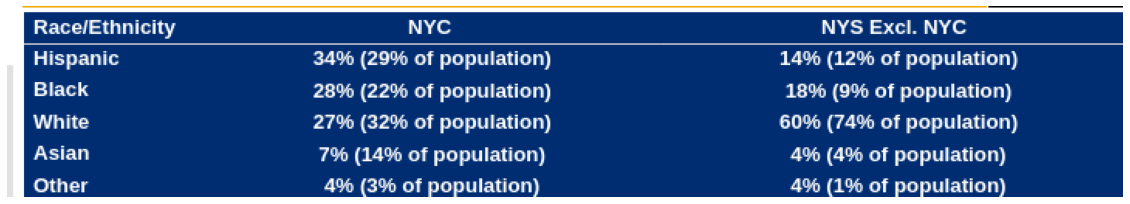

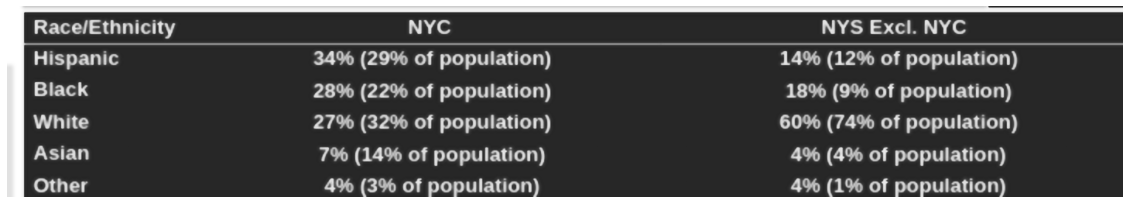

Get raw OCR output from tesseract
Race/Ethnicity

NYC

 

NYS Excl. NYC

 

Hispanic
Black
Sa
Asian
Other

34% (29% of population)
28% (22% of population)
27% (32% of population)
7% (14% of population)
4% (3% of population)

14% (12% of population)
18% (9% of population)
60% (74% of population)
4% (4% of population)
4% (1% of population)
Split OCR text output on newlines and remove blank lines.


,Pct Deaths,Pct Popn
Hispanic,34,29
Black,28,22
White,27,32
Asian,7,14
Other,4,3


,Pct Deaths,Pct Popn
Hispanic,14,12
Black,18,9
White,60,74
Asian,4,4
Other,4,1


{'New York City Only':          Pct Deaths Pct Popn
 Hispanic         34       29
 Black            28       22
 White            27       32
 Asian             7       14
 Other             4        3,
 'New York State excluding New York City':          Pct Deaths Pct Popn
 Hispanic         14       12
 Black            18        9
 White            60       74
 Asian             4        4
 Other             4        1}

In [50]:
ocr_output = ocr_table('New York State'); ocr_output

In [52]:
ocr_output['New York State excluding New York City'].loc['Black']['Pct Deaths']

'18'

In [ ]:
def data_extract_nystate(validation=False, home_dir=None):
    location_name = 'New York State'
    
    print('Navigate to {} data folder'.format(location_name))
    dir = os.path.join(home_dir, 'data', 'ny_state')
    os.chdir(dir)
    
    print('Get OCR output')
    ocr_output =  ocr_table(location_name)
    
    print('Get percent of AA deaths')
    aa_pct_deaths = ocr_output.loc['Black']['Pct Deaths']
    
    
    return {
        'Location': location_name,
        'Date Published': np.nan,
        'Total Cases': np.nan,
        'Total Deaths': np.nan,
        'Count Cases Black/AA': np.nan,
        'Count Deaths Black/AA': np.nan,
        'Pct Cases Black/AA': np.nan,
        'Pct Deaths Black/AA': aa_pct_deaths,
        'Status code': success_code
        }
    
success_code = 'Success!'

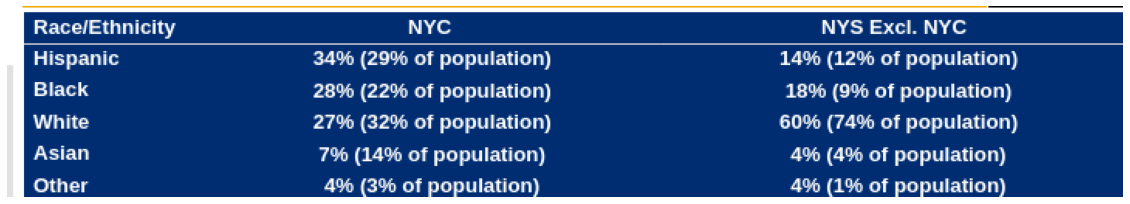

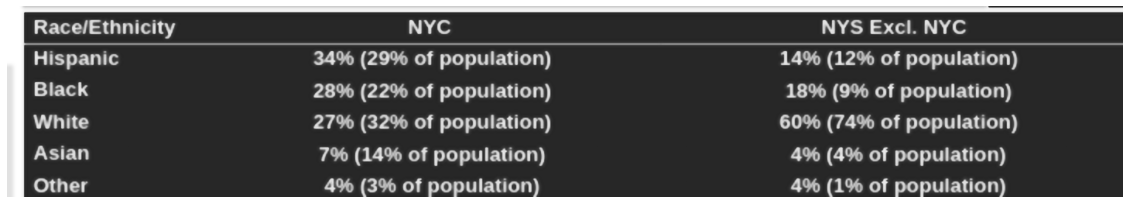

'screenshots/cropped_New York State_preproc.png'

In [16]:
ny_file = 'screenshots/cropped_New York State.png'
image_preprocessing(ny_file)

In [32]:
target_url = 'https://www.arcgis.com/apps/opsdashboard/index.html#/69b726e2b82e408f89c3a54f96e8f776'

In [38]:
location_name  = 'New York State'
port_number = DOCKER_PORT

#target_url = dashboard_urls[location_name] 
#target_url = 'http://ldh.la.gov/Coronavirus/'
output_filename = png_screenshots[location_name]
    
#client = start_docker()
#time.sleep(3)

In [39]:
# docker_url = "http://127.0.0.1:4444/wd/hub" # without selenium-chrome-debug
docker_url = 'http://localhost:{}/wd/hub'.format(port_number)
browser = webdriver.Remote(docker_url, DesiredCapabilities.CHROME)

SessionNotCreatedException: Message: Unable to create new service: ChromeDriverService
Build info: version: '3.141.59', revision: 'e82be7d358', time: '2018-11-14T08:25:53'
System info: host: '7e1a7d367fdb', ip: '172.17.0.2', os.name: 'Linux', os.arch: 'amd64', os.version: '4.19.76-linuxkit', java.version: '1.8.0_252'
Driver info: driver.version: unknown
Stacktrace:
    at org.openqa.selenium.grid.session.remote.ServicedSession$Factory.lambda$get$0 (ServicedSession.java:135)
    at org.openqa.selenium.grid.session.remote.ServicedSession$Factory.apply (ServicedSession.java:152)
    at org.openqa.selenium.remote.server.ActiveSessionFactory.lambda$apply$12 (ActiveSessionFactory.java:180)
    at java.util.stream.ReferencePipeline$3$1.accept (ReferencePipeline.java:193)
    at java.util.stream.ReferencePipeline$11$1.accept (ReferencePipeline.java:440)
    at java.util.stream.ReferencePipeline$2$1.accept (ReferencePipeline.java:175)
    at java.util.Spliterators$ArraySpliterator.tryAdvance (Spliterators.java:958)
    at java.util.stream.ReferencePipeline.forEachWithCancel (ReferencePipeline.java:126)
    at java.util.stream.AbstractPipeline.copyIntoWithCancel (AbstractPipeline.java:499)
    at java.util.stream.AbstractPipeline.copyInto (AbstractPipeline.java:486)
    at java.util.stream.AbstractPipeline.wrapAndCopyInto (AbstractPipeline.java:472)
    at java.util.stream.FindOps$FindOp.evaluateSequential (FindOps.java:152)
    at java.util.stream.AbstractPipeline.evaluate (AbstractPipeline.java:234)
    at java.util.stream.ReferencePipeline.findFirst (ReferencePipeline.java:531)
    at org.openqa.selenium.remote.server.ActiveSessionFactory.apply (ActiveSessionFactory.java:183)
    at org.openqa.selenium.remote.server.NewSessionPipeline.lambda$null$2 (NewSessionPipeline.java:66)
    at java.util.stream.ReferencePipeline$3$1.accept (ReferencePipeline.java:193)
    at java.util.stream.ReferencePipeline$2$1.accept (ReferencePipeline.java:175)
    at java.util.Collections$2.tryAdvance (Collections.java:4719)
    at java.util.stream.ReferencePipeline.forEachWithCancel (ReferencePipeline.java:126)
    at java.util.stream.AbstractPipeline.copyIntoWithCancel (AbstractPipeline.java:499)
    at java.util.stream.AbstractPipeline.copyInto (AbstractPipeline.java:486)
    at java.util.stream.AbstractPipeline.wrapAndCopyInto (AbstractPipeline.java:472)
    at java.util.stream.FindOps$FindOp.evaluateSequential (FindOps.java:152)
    at java.util.stream.AbstractPipeline.evaluate (AbstractPipeline.java:234)
    at java.util.stream.ReferencePipeline.findFirst (ReferencePipeline.java:531)
    at org.openqa.selenium.remote.server.NewSessionPipeline.lambda$createNewSession$3 (NewSessionPipeline.java:69)
    at java.util.stream.ReferencePipeline$3$1.accept (ReferencePipeline.java:193)
    at java.util.stream.ReferencePipeline$3$1.accept (ReferencePipeline.java:193)
    at java.util.stream.ReferencePipeline$3$1.accept (ReferencePipeline.java:193)
    at java.util.stream.DistinctOps$1$2.accept (DistinctOps.java:175)
    at java.util.stream.ReferencePipeline$2$1.accept (ReferencePipeline.java:175)
    at java.util.stream.ReferencePipeline$3$1.accept (ReferencePipeline.java:193)
    at java.util.stream.ReferencePipeline$2$1.accept (ReferencePipeline.java:175)
    at java.util.stream.Streams$StreamBuilderImpl.tryAdvance (Streams.java:405)
    at java.util.stream.Streams$ConcatSpliterator.tryAdvance (Streams.java:728)
    at java.util.stream.ReferencePipeline.forEachWithCancel (ReferencePipeline.java:126)
    at java.util.stream.AbstractPipeline.copyIntoWithCancel (AbstractPipeline.java:499)
    at java.util.stream.AbstractPipeline.copyInto (AbstractPipeline.java:486)
    at java.util.stream.AbstractPipeline.wrapAndCopyInto (AbstractPipeline.java:472)
    at java.util.stream.FindOps$FindOp.evaluateSequential (FindOps.java:152)
    at java.util.stream.AbstractPipeline.evaluate (AbstractPipeline.java:234)
    at java.util.stream.ReferencePipeline.findFirst (ReferencePipeline.java:531)
    at org.openqa.selenium.remote.server.NewSessionPipeline.createNewSession (NewSessionPipeline.java:72)
    at org.openqa.selenium.remote.server.commandhandler.BeginSession.execute (BeginSession.java:65)
    at org.openqa.selenium.remote.server.WebDriverServlet.lambda$handle$0 (WebDriverServlet.java:235)
    at java.util.concurrent.Executors$RunnableAdapter.call (Executors.java:511)
    at java.util.concurrent.FutureTask.run (FutureTask.java:266)
    at java.util.concurrent.ThreadPoolExecutor.runWorker (ThreadPoolExecutor.java:1149)
    at java.util.concurrent.ThreadPoolExecutor$Worker.run (ThreadPoolExecutor.java:624)
    at java.lang.Thread.run (Thread.java:748)

In [16]:
browser.get(target_url)

In [114]:
#browser.execute_script("window.scrollTo(0, 0);")  # scroll to top of page
browser.set_window_position(x=0,y=50)
browser.set_window_size(1024, 600)
browser.maximize_window()

WebDriverException: Message: unknown error: session deleted because of page crash
from unknown error: cannot determine loading status
from tab crashed
  (Session info: chrome=83.0.4103.61)


In [99]:
browser.execute_script("window.scrollTo(0, 600);")  # scroll to top of page

Screenshot saved to screenshots/screenshot_ny.png


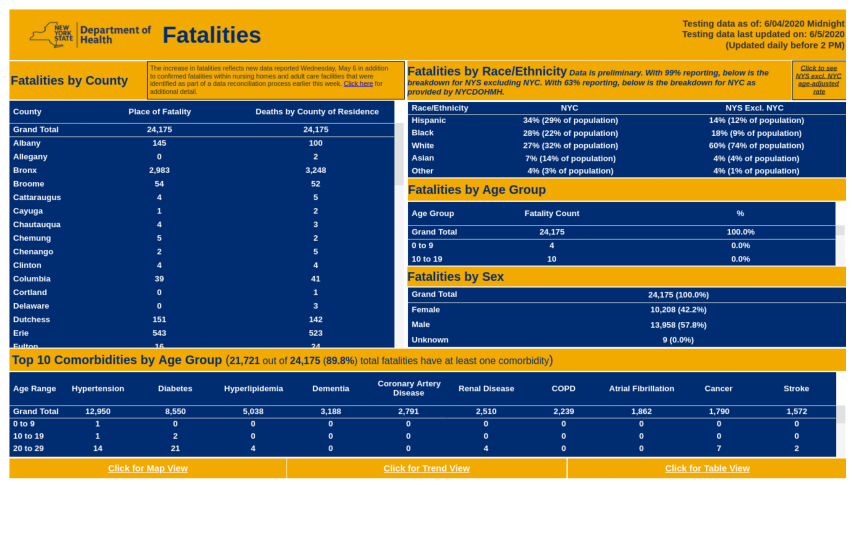

In [20]:
#time.sleep(sleep_seconds)
png_filename = os.path.join('screenshots', "{}.png".format(output_filename))
browser.save_screenshot(png_filename)
print('Screenshot saved to {}'.format(png_filename))
display_image(png_filename)

In [21]:
stop_docker(client)

In [24]:
os.listdir(os.path.join(home_dir, 'screenshots'))

['screenshot_ny.png',
 'screenshot.png',
 'screenshot_louisiana.png',
 'cropped_Louisiana.png',
 'myfile.png',
 'cropped_New York State_preproc.png',
 'cropped_New York State.png',
 'cropped_Louisiana_preproc.png',
 'screenshot_louisiana_endofpage.png']

In [ ]:
browser

In [118]:
browser.close()

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=83.0.4103.61)


In [ ]:




#time.sleep(10)
browser.close()
if show_image:
    display_image(png_filename)

#return browser
stop_docker(client)



In [108]:
stop_docker(client)

Error stopping docker container
'NoneType' object has no attribute 'containers'


In [ ]:

{
        'Location': 'Massachusetts',
        'Date Published': mass_max_date,
        'Total Cases': mass_total_cases,
        'Total Deaths': mass_total_deaths,
        'Count Cases Black/AA': mass_aa_cases,
        'Count Deaths Black/AA': mass_aa_deaths,
        'Pct Cases Black/AA': mass_aa_cases_pct,
        'Pct Deaths Black/AA': mass_aa_deaths_pct,
        'Status code': success_code
        }

In [ ]:
from misc_helper_functions import download_file
file_url = 'blob:https://ladhh.maps.arcgis.com/41833d11-db6f-49ef-9394-5fde35a1ca25'
os.chdir('data/louisiana')

In [ ]:
download_file(file_url)

In [ ]:
from bs4 import BeautifulSoup

In [41]:
location_name =  'Louisiana'
#target_url = 'https://ladhh.maps.arcgis.com/apps/webappviewer/index.html?id=3b9b6f22d92f4d688f1c21e9d154cae2'
target_url = 'http://ldh.la.gov/Coronavirus/'
output_filename = png_screenshots[location_name]
opts = webdriver.ChromeOptions()
opts.add_argument("--kiosk")
#opts.add_argument('headless')
browser = webdriver.Chrome(executable_path = DRIVER_BIN, options=opts)
browser.set_window_size(1024, 600)
browser.maximize_window()
browser.get(target_url)

In [103]:
#target_url = 'http://ldh.la.gov/Coronavirus/'
target_url = 'https://ladhh.maps.arcgis.com/apps/webappviewer/index.html?id=3b9b6f22d92f4d688f1c21e9d154cae2'
browser.get(target_url)


WebDriverException: Message: unknown error: session deleted because of page crash
from tab crashed
  (Session info: chrome=83.0.4103.61)


In [29]:
browser.find_element_by_id('ember895').click()

ElementNotInteractableException: Message: Element <label id="ember895" class="ember-view"> could not be scrolled into view


In [45]:
txt = browser.find_element_by_xpath("//div[@id='ember971']")
browser.find_element_by_xpath(txt)

NoSuchElementException: Message: Unable to locate element: //div[@id="ember971"]


In [12]:
browser.find_element_by_xpath('//button[normalize-space()="OK"]').click()

In [30]:
# https://stackoverflow.com/questions/48672814/clicking-a-button-with-selenium-in-python

def click_button(browser, button_txt):
    browser. \
    find_element_by_xpath('//button[normalize-space()="{}"]'.format(button_txt)) \
    .click()
    
def click_tab(browser, tab_id_name):
    browser.  \
    find_element_by_id(id_name). \
    click()

In [31]:
#click_button(browser, 'OK')
click_button(browser, 'Deaths by Race by Parish')
#click_button(browser, '▶')
#click_tab(browser, 'dijit_layout_TabContainer_0_tablist_rightBtn')
##click_tab(browser, 'dijit_layout_TabContainer_0_tablist_dijit_layout_ContentPane_9')
#click_tab(browser, 'dijit_form_DropDownButton_1_label')

#click_tab(browser, None)

NoSuchElementException: Message: Unable to locate element: //button[normalize-space()="Deaths by Race by Parish"]


In [1]:
browser.close()

NameError: name 'browser' is not defined

# Stop Docker

In [53]:
stop_docker(client)